In [1]:
#import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [4]:
#visualize the dataset
def imshow(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


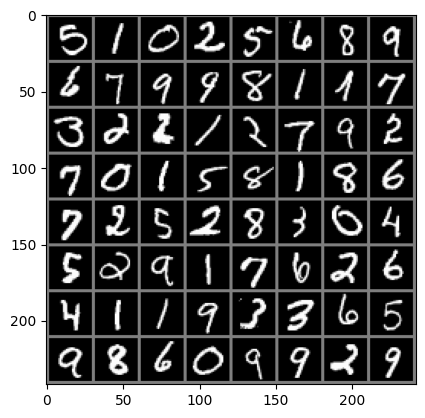

In [5]:
imshow(trainloader)

In [6]:
for images, labels in trainloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [35]:
#LSTM generator
class LSTM_Generator(nn.Module):
    '''
    LSTM takes a random noise and generate synthetic images
    '''
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Generator, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.sequential = nn.Sequential(
            nn.Linear(hidden_size, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        #print(x.shape)
        x = self.sequential(x[:, -1, :])
        #x = x.view(-1, 1, 28, 28)
        return x.view(-1, 1, 28, 28)

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [37]:
input_size = 28
hidden_size = 100
num_layers = 2
G = LSTM_Generator(input_size, hidden_size, num_layers).to(device)

In [38]:
#feed a random noise to the generator
noise = torch.randn(64, 28, 28).to(device)
fake_images = G(noise)
print(fake_images.shape)

torch.Size([64, 1, 28, 28])


In [39]:
#lstm discriminator
class LSTM_Discriminator(nn.Module):
    '''
    LSTM takes a synthetic image and generate a score
    '''
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Discriminator, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.sequential = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(1)
        x, _ = self.lstm(x)
        x = self.sequential(x[:, -1, :])
        return x

In [40]:
input_size = 28
hidden_size = 100
num_layers = 1
D = LSTM_Discriminator(input_size, hidden_size, num_layers).to(device)

In [41]:
fake_images.shape

torch.Size([64, 1, 28, 28])

In [42]:
#feed the generated image to the discriminator
d_out = D(fake_images)
print(d_out.shape)

torch.Size([64, 1])


In [43]:
#loss function
criterion = nn.BCELoss()

#optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

In [44]:
for images, labels in trainloader:
    images = images.to(device)
    print(images.shape)
    out = D(images)
    print(out.shape)    
    break

torch.Size([64, 1, 28, 28])
torch.Size([64, 1])


In [45]:
#training
num_epochs = 50
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(trainloader):
        images = images.to(device)
        batch_size = images.shape[0]

        #train the discriminator
        D.zero_grad()
        #real images
        d_out = D(images.view(batch_size, 1, 28, 28))
        real_labels = torch.ones_like(d_out)
        d_loss_real = criterion(d_out, real_labels)
        d_loss_real.backward()

        #fake images
        noise = torch.randn(batch_size, 28, 28).to(device)
        fake_images = G(noise)
        d_out = D(fake_images)
        fake_labels = torch.zeros_like(d_out)
        d_loss_fake = criterion(d_out, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        D_optimizer.step()

        #train the generator
        G.zero_grad()
        noise = torch.randn(batch_size, 28, 28).to(device)
        fake_images = G(noise)
        d_out = D(fake_images)
        g_loss = criterion(d_out, real_labels)
        g_loss.backward()
        G_optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(trainloader), d_loss.item(), g_loss.item()))

Epoch [1/50], Step [100/938], d_loss: 1.1540, g_loss: 0.6866
Epoch [1/50], Step [200/938], d_loss: 1.3799, g_loss: 0.7350
Epoch [1/50], Step [300/938], d_loss: 1.3612, g_loss: 0.6022
Epoch [1/50], Step [400/938], d_loss: 0.4380, g_loss: 1.0824
Epoch [1/50], Step [500/938], d_loss: 0.0776, g_loss: 2.8196
Epoch [1/50], Step [600/938], d_loss: 0.0407, g_loss: 3.5967
Epoch [1/50], Step [700/938], d_loss: 0.0159, g_loss: 4.7666
Epoch [1/50], Step [800/938], d_loss: 0.0107, g_loss: 5.2376
Epoch [1/50], Step [900/938], d_loss: 0.0082, g_loss: 5.5143
Epoch [2/50], Step [100/938], d_loss: 0.0062, g_loss: 5.7799
Epoch [2/50], Step [200/938], d_loss: 0.0052, g_loss: 5.9209
Epoch [2/50], Step [300/938], d_loss: 0.0044, g_loss: 6.1163
Epoch [2/50], Step [400/938], d_loss: 0.0042, g_loss: 6.0665
Epoch [2/50], Step [500/938], d_loss: 0.0035, g_loss: 6.2744
Epoch [2/50], Step [600/938], d_loss: 0.0030, g_loss: 6.4470
Epoch [2/50], Step [700/938], d_loss: 0.0033, g_loss: 6.2327
Epoch [2/50], Step [800/

KeyboardInterrupt: 

In [46]:
#gernerate images
noise = torch.randn(64, 28,28).to(device)
fake_images = G(noise)
fake_images = fake_images.view(-1, 28, 28).cpu().detach().numpy()

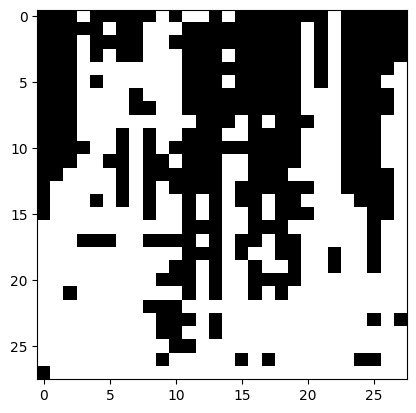

In [47]:
plt.imshow(fake_images[0], cmap='gray')